# BIBLIOTECAS

In [ ]:
!pip install pandas numpy matplotlib scikit-learn tensorflow

# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
#Carregamento do modelo e extração dos parametros
from keras.models import load_model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# BLOCO_DADOS DE CHUVA REGISTRO HISTÓRICO SÉRIE DE 2011 AO FINAL DE 2024

In [ ]:
df = pd.read_excel('/content/drive/My Drive/IA/copia_dataset_modelo.xlsx', sheet_name='nivel mais 1')
#dataset

# VERIFICAÇÃO, AJUSTES E LIMPEZA DOS DADOS

In [ ]:
if np.issubdtype(df['HORA'].dtype, np.number):
    df['HORA'] = pd.to_timedelta(df['HORA'], unit='d')  # Fração de dia em horas
    df['HoraFormatada'] = df['HORA'].astype(str).str.split(' ').str[-1]  # Extrai só HH:MM:SS
else:
    df['HoraFormatada'] = df['HORA'].astype(str)

In [ ]:
if np.issubdtype(df['HORA'].dtype, np.datetime64):
    # Hora no formato HH:MM:SS
    df['HoraFormatada'] = df['HORA'].dt.strftime('%H:%M:%S')
elif np.issubdtype(df['HORA'].dtype, np.number):
    # Fração do dia no Excel
    df['HoraFormatada'] = (pd.to_timedelta(df['HORA'], unit='d')).astype(str).str.split().str[-1]
else:
    # Se for texto
    df['HoraFormatada'] = df['HORA'].astype(str)

In [ ]:
df['DataHora'] = pd.to_datetime(df['DATA'].astype(str) + ' ' + df['HoraFormatada'], dayfirst=True, errors='coerce')

/tmp/ipython-input-6-1654509681.py:1: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['DataHora'] = pd.to_datetime(df['DATA'].astype(str) + ' ' + df['HoraFormatada'], dayfirst=True, errors='coerce')


In [ ]:
df

,DATA,HORA,CHUVA CORRIGIDA,NIVEL CORRIGIDO,chuva_ultima_1h,chuva_ultimas_2h,chuva_ultimas_4h,chuva_ultimas_24h,NIVEL+1,HoraFormatada,DataHora
0,2011-10-25,21:00:00,0.0,0.48000,0.0,0.0,0.0,0.0,0.48000,21:00:00,2011-10-25 21:00:00
1,2011-10-25,21:15:00,0.5,0.48000,0.0,0.0,0.0,0.0,0.48000,21:15:00,2011-10-25 21:15:00
2,2011-10-25,21:30:00,0.0,0.48000,0.0,0.0,0.0,0.0,0.48000,21:30:00,2011-10-25 21:30:00
3,2011-10-25,21:45:00,0.0,0.48000,0.5,0.0,0.0,0.0,0.48000,21:45:00,2011-10-25 21:45:00
4,2011-10-25,22:00:00,0.0,0.48000,0.5,0.0,0.0,0.0,0.48000,22:00:00,2011-10-25 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...
393364,2024-12-31,19:45:00,0.0,1.00498,0.0,0.0,0.0,0.2,1.00493,19:45:00,2024-12-31 19:45:00
393365,2024-12-31,20:00:00,0.0,1.00493,0.0,0.0,0.0,0.2,1.00521,20:00:00,2024-12-31 20:00:00
393366,2024-12-31,20:15:00,0.0,1.00521,0.0,0.0,0.0,0.2,1.00501,20:15:00,2024-12-31 20:15:00
393367,2024-12-31,20:30:00,0.0,1.00501,0.0,0.0,0.0,0.2,1.00444,20:30:00,2024-12-31 20:30:00


In [ ]:
# Verificação de NaNs
print(df.isnull().sum())

# Remover linhas que eventualmente tenham NaN
df = df.dropna()

# Conferir novamente
print(df.isnull().sum())

DATA                  0
HORA                  0
CHUVA CORRIGIDA       0
NIVEL CORRIGIDO       0
chuva_ultima_1h       0
chuva_ultimas_2h      0
chuva_ultimas_4h      0
chuva_ultimas_24h     0
NIVEL+1               1
HoraFormatada         0
DataHora             12
dtype: int64
DATA                 0
HORA                 0
CHUVA CORRIGIDA      0
NIVEL CORRIGIDO      0
chuva_ultima_1h      0
chuva_ultimas_2h     0
chuva_ultimas_4h     0
chuva_ultimas_24h    0
NIVEL+1              0
HoraFormatada        0
DataHora             0
dtype: int64


In [ ]:
df

,DATA,HORA,CHUVA CORRIGIDA,NIVEL CORRIGIDO,chuva_ultima_1h,chuva_ultimas_2h,chuva_ultimas_4h,chuva_ultimas_24h,NIVEL+1,HoraFormatada,DataHora
0,2011-10-25,21:00:00,0.0,0.48000,0.0,0.0,0.0,0.0,0.48000,21:00:00,2011-10-25 21:00:00
1,2011-10-25,21:15:00,0.5,0.48000,0.0,0.0,0.0,0.0,0.48000,21:15:00,2011-10-25 21:15:00
2,2011-10-25,21:30:00,0.0,0.48000,0.0,0.0,0.0,0.0,0.48000,21:30:00,2011-10-25 21:30:00
3,2011-10-25,21:45:00,0.0,0.48000,0.5,0.0,0.0,0.0,0.48000,21:45:00,2011-10-25 21:45:00
4,2011-10-25,22:00:00,0.0,0.48000,0.5,0.0,0.0,0.0,0.48000,22:00:00,2011-10-25 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...
393363,2024-12-31,19:30:00,0.0,1.00475,0.0,0.0,0.0,0.2,1.00498,19:30:00,2024-12-31 19:30:00
393364,2024-12-31,19:45:00,0.0,1.00498,0.0,0.0,0.0,0.2,1.00493,19:45:00,2024-12-31 19:45:00
393365,2024-12-31,20:00:00,0.0,1.00493,0.0,0.0,0.0,0.2,1.00521,20:00:00,2024-12-31 20:00:00
393366,2024-12-31,20:15:00,0.0,1.00521,0.0,0.0,0.0,0.2,1.00501,20:15:00,2024-12-31 20:15:00


# SELEÇÃO DAS VARIAVEIS (ENTRADA X SAIDA)

In [ ]:
input_features = ['CHUVA CORRIGIDA', 'chuva_ultima_1h', 'chuva_ultimas_2h',
                  'chuva_ultimas_4h', 'chuva_ultimas_24h', 'NIVEL CORRIGIDO']
target = 'NIVEL CORRIGIDO'


# ESCALONAMENTO DE DADOS

In [ ]:
X = df[input_features].values
y = df[target].values

# Inicializar os escalonadores
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Aplicar o escalonamento
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
dados = df[input_features]


# NORMALIZAÇÃO

In [ ]:
scaler = MinMaxScaler()
dados_scaled = scaler.fit_transform(dados)

# SEQUENCIAS TEMPORAIS

In [ ]:
def create_sequences(X, y, timestep=16, horizon=4):  # 16 passos = 4 horas se dados são de 15min (horizon = 4 - 1hora na frente)
    Xs, ys = [], []
    for i in range(timestep, len(X)-horizon + 1):
        Xs.append(X[i - timestep:i])
        ys.append(y[i + horizon - 1])
    return np.array(Xs), np.array(ys)

# Gerar as sequências
timestep = 16
horizon = 4
X_seq, y_seq = create_sequences(X_scaled, y_scaled, timestep, horizon)

print("Shape das entradas:", X_seq.shape)
print("Shape das saídas:", y_seq.shape)


Shape das entradas: (393337, 16, 6)
Shape das saídas: (393337, 1)


# TREINO X TESTE

In [ ]:
train_size = int(0.8 * len(X_seq))

X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print("Tamanho treino:", X_train.shape)
print("Tamanho teste:", X_test.shape)


Tamanho treino: (314669, 16, 6)
Tamanho teste: (78668, 16, 6)


#MODELO

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16, 100)        │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,051 (285.36 KB)

 Trainable params: 73,051 (285.36 KB)

 Non-trainable params: 0 (0.00 B)

#TREINAMENTO

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)


Epoch 1/50
7867/7867 ━━━━━━━━━━━━━━━━━━━━ 168s 21ms/step - loss: 4.2020e-04 - val_loss: 7.5670e-04
Epoch 2/50
7867/7867 ━━━━━━━━━━━━━━━━━━━━ 170s 22ms/step - loss: 3.5832e-04 - val_loss: 6.0376e-04
Epoch 3/50
7867/7867 ━━━━━━━━━━━━━━━━━━━━ 193s 20ms/step - loss: 3.5264e-04 - val_loss: 5.6736e-04
Epoch 4/50
7867/7867 ━━━━━━━━━━━━━━━━━━━━ 209s 21ms/step - loss: 3.2766e-04 - val_loss: 5.6592e-04
Epoch 5/50
7867/7867 ━━━━━━━━━━━━━━━━━━━━ 202s 21ms/step - loss: 3.4158e-04 - val_loss: 6.0309e-04
Epoch 6/50
7867/7867 ━━━━━━━━━━━━━━━━━━━━ 204s 22ms/step - loss: 3.4728e-04 - val_loss: 6.0039e-04
Epoch 7/50
7867/7867 ━━━━━━━━━━━━━━━━━━━━ 200s 21ms/step - loss: 3.2513e-04 - val_loss: 5.7800e-04
Epoch 8/50
7867/7867 ━━━━━━━━━━━━━━━━━━━━ 161s 20ms/step - loss: 3.2210e-04 - val_loss: 5.2960e-04
Epoch 9/50
7867/7867 ━━━━━━━━━━━━━━━━━━━━ 212s 22ms/step - loss: 3.3884e-04 - val_loss: 5.7610e-04
Epoch 10/50
7867/7867 ━━━━━━━━━━━━━━━━━━━━ 200s 21ms/step - loss: 3.3932e-04 - val_loss: 5.3240e-04
Epoch 11/

In [ ]:
model.save("modelo_previsao.keras")

#AVALIAÇÃO

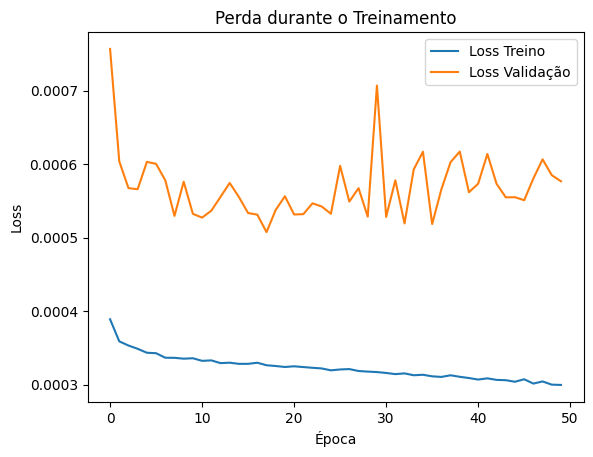

In [ ]:
plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.title('Perda durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

#PREVISÃO DE CHEIA

2459/2459 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step


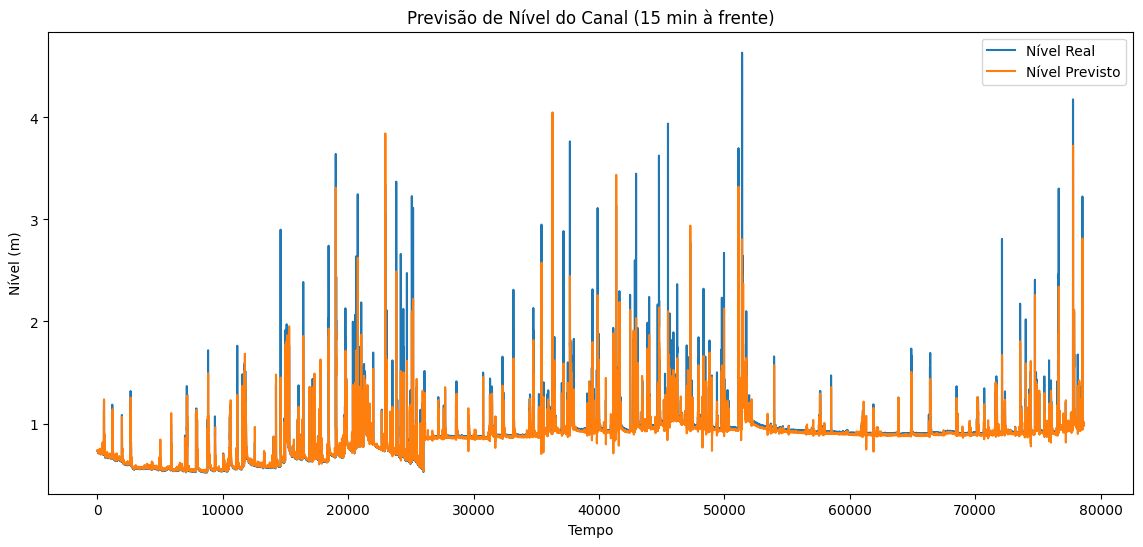

In [ ]:
y_pred_scaled = model.predict(X_test)

# Desescalar
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_real = scaler_y.inverse_transform(y_test)

# Plotar comparação
plt.figure(figsize=(14,6))
plt.plot(y_real, label='Nível Real')
plt.plot(y_pred, label='Nível Previsto')
plt.title('Previsão de Nível do Canal (15 min à frente)')
plt.xlabel('Tempo')
plt.ylabel('Nível (m)')
plt.legend()
plt.show()


#PREVISÃO PROXIMOS 15 MINUTOS

In [ ]:
ultima_sequencia = X_scaled[-timestep:]
X_input = ultima_sequencia.reshape((1, timestep, X_scaled.shape[1]))

y_future_scaled = model.predict(X_input)
y_future = scaler_y.inverse_transform(y_future_scaled)

print(f'Previsão do nível para os próximos 15 minutos: {y_future[0][0]:.2f} m')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Previsão do nível para os próximos 15 minutos: 0.98 m


#ESTATISTICA

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_real, y_pred))
r2 = r2_score(y_real, y_pred)

print(f'RMSE: {rmse:.2f} m')
print(f'R²: {r2:.2f}')

RMSE: 0.11 m
R²: 0.75


# BLOCO_DADOS DE CHUVA VALIDAÇÃO PARA O ANO DE 2025 JANEIRO A ABRIL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df2 = pd.read_excel('/content/drive/My Drive/IA/arquivo_coronel_veiga_2025_modif.xlsx', sheet_name='2025')
#dataset

# VERIFICAÇÃO, AJUSTES E LIMPEZA DOS DADOS (2025)

In [ ]:
if np.issubdtype(df2['HORA'].dtype, np.number):
    df2['HORA'] = pd.to_timedelta(df2['HORA'], unit='d')  # Fração de dia em horas
    df2['HoraFormatada'] = df2['HORA'].astype(str).str.split(' ').str[-1]  # Extrai só HH:MM:SS
else:
    df2['HoraFormatada'] = df2['HORA'].astype(str)

In [ ]:
if np.issubdtype(df2['HORA'].dtype, np.datetime64):
    # Hora no formato HH:MM:SS
    df2['HoraFormatada'] = df2['HORA'].dt.strftime('%H:%M:%S')
elif np.issubdtype(df['HORA'].dtype, np.number):
    # Fração do dia no Excel
    df2['HoraFormatada'] = (pd.to_timedelta(df2['HORA'], unit='d')).astype(str).str.split().str[-1]
else:
    # Se for texto
    df2['HoraFormatada'] = df2['HORA'].astype(str)

In [ ]:
df2['DataHora'] = pd.to_datetime(df2['DATA'].astype(str) + ' ' + df2['HoraFormatada'], dayfirst=True, errors='coerce')

In [ ]:
df2

,DATA,HORA,CHUVA CORRIGIDA,NIVEL CORRIGIDO,chuva_ultima_1h,chuva_ultimas_2h,chuva_ultimas_4h,chuva_ultimas_24h,HoraFormatada,DataHora
0,2025-01-01,00:00:00,0.0,1.00412,0.0,0.0,0.0,0.0,00:00:00,2025-01-01 00:00:00
1,2025-01-01,00:15:00,0.0,1.00417,0.0,0.0,0.0,0.0,00:15:00,2025-01-01 00:15:00
2,2025-01-01,00:30:00,0.0,1.00378,0.0,0.0,0.0,0.0,00:30:00,2025-01-01 00:30:00
3,2025-01-01,00:45:00,0.0,1.00326,0.0,0.0,0.0,0.0,00:45:00,2025-01-01 00:45:00
4,2025-01-01,01:00:00,0.0,1.00268,0.0,0.0,0.0,0.0,01:00:00,2025-01-01 01:00:00
...,...,...,...,...,...,...,...,...,...,...
8728,2025-04-01,22:15:00,0.0,1.13508,1.4,7.8,8.0,8.0,22:15:00,2025-01-04 22:15:00
8729,2025-04-01,22:30:00,0.0,1.07094,1.2,4.6,8.0,8.0,22:30:00,2025-01-04 22:30:00
8730,2025-04-01,22:45:00,0.0,1.03592,0.4,2.0,8.0,8.0,22:45:00,2025-01-04 22:45:00
8731,2025-04-01,23:00:00,0.0,1.01061,0.0,1.4,8.0,8.0,23:00:00,2025-01-04 23:00:00


In [ ]:
# Verificação de NaNs
print(df.isnull().sum())

# Remover linhas que eventualmente tenham NaN
df = df.dropna()

# Conferir novamente
print(df.isnull().sum())

DATA                 0
HORA                 0
CHUVA CORRIGIDA      0
NIVEL CORRIGIDO      0
chuva_ultima_1h      0
chuva_ultimas_2h     0
chuva_ultimas_4h     0
chuva_ultimas_24h    0
NIVEL+1              0
HoraFormatada        0
DataHora             0
dtype: int64
DATA                 0
HORA                 0
CHUVA CORRIGIDA      0
NIVEL CORRIGIDO      0
chuva_ultima_1h      0
chuva_ultimas_2h     0
chuva_ultimas_4h     0
chuva_ultimas_24h    0
NIVEL+1              0
HoraFormatada        0
DataHora             0
dtype: int64


In [ ]:
df2

,DATA,HORA,CHUVA CORRIGIDA,NIVEL CORRIGIDO,chuva_ultima_1h,chuva_ultimas_2h,chuva_ultimas_4h,chuva_ultimas_24h,HoraFormatada,DataHora
0,2025-01-01,00:00:00,0.0,1.00412,0.0,0.0,0.0,0.0,00:00:00,2025-01-01 00:00:00
1,2025-01-01,00:15:00,0.0,1.00417,0.0,0.0,0.0,0.0,00:15:00,2025-01-01 00:15:00
2,2025-01-01,00:30:00,0.0,1.00378,0.0,0.0,0.0,0.0,00:30:00,2025-01-01 00:30:00
3,2025-01-01,00:45:00,0.0,1.00326,0.0,0.0,0.0,0.0,00:45:00,2025-01-01 00:45:00
4,2025-01-01,01:00:00,0.0,1.00268,0.0,0.0,0.0,0.0,01:00:00,2025-01-01 01:00:00
...,...,...,...,...,...,...,...,...,...,...
8728,2025-04-01,22:15:00,0.0,1.13508,1.4,7.8,8.0,8.0,22:15:00,2025-01-04 22:15:00
8729,2025-04-01,22:30:00,0.0,1.07094,1.2,4.6,8.0,8.0,22:30:00,2025-01-04 22:30:00
8730,2025-04-01,22:45:00,0.0,1.03592,0.4,2.0,8.0,8.0,22:45:00,2025-01-04 22:45:00
8731,2025-04-01,23:00:00,0.0,1.01061,0.0,1.4,8.0,8.0,23:00:00,2025-01-04 23:00:00


# VALIDAÇÃO COM O PERÍODO DE 2025

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


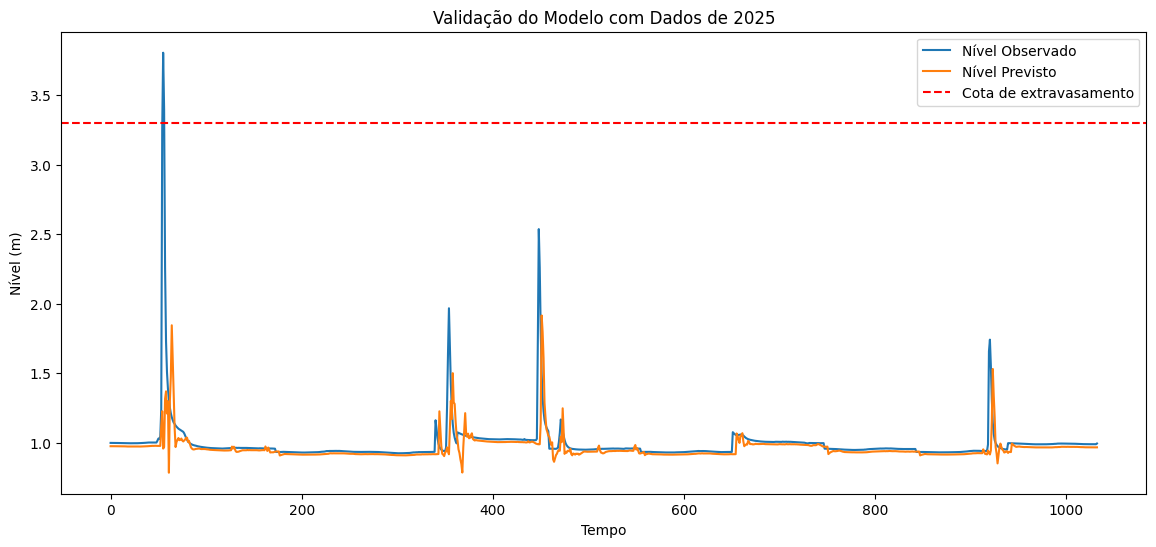

RMSE validação: 0.17 m
R² validação: 0.06


In [ ]:
# --- Etapa 14: Validação com dados de 2025 ---

# Parâmetros usados no modelo
timestep = 16
horizon = 4

# Carregar o modelo salvo
from keras.models import load_model
modelo_carregado = load_model("modelo_previsao.keras")

# Preprocessamento para df2 (iguais aos feitos para df)
df2 = pd.read_excel('/content/drive/My Drive/IA/arquivo_coronel_veiga_2025_modif.xlsx', sheet_name='2025')

# Ajustar a hora
if np.issubdtype(df2['HORA'].dtype, np.datetime64):
    df2['HoraFormatada'] = df2['HORA'].dt.strftime('%H:%M:%S')
elif np.issubdtype(df2['HORA'].dtype, np.number):
    df2['HoraFormatada'] = (pd.to_timedelta(df2['HORA'], unit='d')).astype(str).str.split().str[-1]
else:
    df2['HoraFormatada'] = df2['HORA'].astype(str)

# Criar coluna de data e hora
df2['DataHora'] = pd.to_datetime(df2['DATA'].astype(str) + ' ' + df2['HoraFormatada'], dayfirst=True, errors='coerce')

# Eliminar valores faltantes
df2 = df2.dropna()

# Sort the DataFrame by 'DataHora' before setting it as index
df2 = df2.sort_values(by='DataHora')

# Selecionar intervalo de validação
evento_inicio = '2025-01-01 00:00:00'
evento_fim = '2025-04-01 23:15:00'
df_evento = df2.set_index('DataHora').loc[evento_inicio:evento_fim]

# Verifica se há dados suficientes
if len(df_evento) < (timestep + horizon):
    print(f"Dados insuficientes: necessário pelo menos {timestep + horizon} linhas. Temos apenas {len(df_evento)}.")
else:
    # Preparar os dados
    X_evento = df_evento[input_features].values
    y_evento = df_evento[target].values

    # Escalonar com os mesmos scalers do treino
    X_evento_scaled = scaler_X.transform(X_evento)
    y_evento_scaled = scaler_y.transform(y_evento.reshape(-1, 1))

    # Gerar as sequências
    X_seq_evento, y_seq_evento = create_sequences(X_evento_scaled, y_evento_scaled, timestep, horizon)

    # Previsão
    y_pred_evento_scaled = modelo_carregado.predict(X_seq_evento)
    y_pred_evento = scaler_y.inverse_transform(y_pred_evento_scaled)
    y_real_evento = scaler_y.inverse_transform(y_seq_evento)

    # Plotar os resultados
    plt.figure(figsize=(14,6))
    plt.plot(y_real_evento, label='Nível Observado')
    plt.plot(y_pred_evento, label='Nível Previsto')
    plt.axhline(3.3, color='red', linestyle='--', label='Cota de extravasamento')
    plt.title('Validação do Modelo com Dados de 2025')
    plt.xlabel('Tempo')
    plt.ylabel('Nível (m)')
    plt.legend()
    plt.show()

    # Avaliação estatística
    rmse_val = np.sqrt(mean_squared_error(y_real_evento, y_pred_evento))
    r2_val = r2_score(y_real_evento, y_pred_evento)

    print(f'RMSE validação: {rmse_val:.2f} m')
    print(f'R² validação: {r2_val:.2f}')